# Creating the submission

In [1]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder


### Conclusion for submission

Based on the tests that were conducted the xgboost_model_1 was the most accurate.

The following variables were used in the modelling: 
1. OverallQual
2. InternalSF 
3. GrLivArea
4. GarageCars
5. GarageArea
6. FullBath
7. YearBuilt
8. TotalBsmtSF
9. YearRemodAdd
10. 1stFlrSF
11. BsmtFinSF1
12. LotArea 
13. LotFrontage
14. Fireplaces
15. OverallCond
16. ExterQual_TA
17. Neighborhood_Price_Bucket_Level_1
18. Neighborhood_Price_Bucket_Level_4
19. KitchenQual_Gd
20. Neighborhood_Price_Bucket_Level_3

In [2]:
# Import the data
df = pd.read_csv('raw_data/test.csv')

# Show the first 5 rows of the data
df.head(5)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [3]:
# Show the features in the data that have missing values and the number of missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Get the data types of the features with missing values
missing_values_data_types = df.dtypes[missing_values.index]

# Combine the missing values and data types into a single DataFrame
missing_values_info = pd.DataFrame({'Missing Values': missing_values, 'Data Type': missing_values_data_types})

print(missing_values_info)

              Missing Values Data Type
MSZoning                   4    object
LotFrontage              227   float64
Alley                   1352    object
Utilities                  2    object
Exterior1st                1    object
Exterior2nd                1    object
MasVnrType               894    object
MasVnrArea                15   float64
BsmtQual                  44    object
BsmtCond                  45    object
BsmtExposure              44    object
BsmtFinType1              42    object
BsmtFinSF1                 1   float64
BsmtFinType2              42    object
BsmtFinSF2                 1   float64
BsmtUnfSF                  1   float64
TotalBsmtSF                1   float64
BsmtFullBath               2   float64
BsmtHalfBath               2   float64
KitchenQual                1    object
Functional                 2    object
FireplaceQu              730    object
GarageType                76    object
GarageYrBlt               78   float64
GarageFinish             

In [4]:
import pandas as pd

# Replace NaN values in numerical columns with median
df.fillna({col: df[col].median() for col in df.select_dtypes(include=['number']).columns}, inplace=True)

# Replace NaN values in object columns with 'Not Applicable'
df.fillna({col: 'Not Applicable' for col in df.select_dtypes(include=['object']).columns}, inplace=True)

# Display confirmation of completion
print("NaN values replaced: Numerical columns -> Median, Object columns -> 'Not Applicable'")


NaN values replaced: Numerical columns -> Median, Object columns -> 'Not Applicable'


In [ ]:
# Check that there are in fact no missing values in the data
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Get the data types of the features with missing values
missing_values_data_types = df.dtypes[missing_values.index]

# Combine the missing values and data types into a single DataFrame
missing_values_info = pd.DataFrame({'Missing Values': missing_values, 'Data Type': missing_values_data_types})

print(missing_values_info)

Empty DataFrame
Columns: [Missing Values, Data Type]
Index: []


In [6]:
# Create a feature called InternalSF
df['InternalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']

In [7]:
# Create PorchDeckSF feature
df['PorchDeckSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

In [8]:
neighborhood_price_mapping = {
    'OldTown': 'Level_1', 'BrkSide': 'Level_1', 'IDOTRR': 'Level_1', 'MeadowV': 'Level_1', 'Edwards': 'Level_1', 'BrDale': 'Level_1',
    'Mitchel': 'Level_2', 'Sawyer': 'Level_2', 'NAmes': 'Level_2', 'NPkVill': 'Level_2', 'SWISU': 'Level_2', 'Blueste': 'Level_2',
    'CollgCr': 'Level_3', 'NWAmes': 'Level_3', 'SawyerW': 'Level_3', 'Gilbert': 'Level_3', 'ClearCr': 'Level_3', 'Blmngtn': 'Level_3',
    'Veenker': 'Level_4', 'Crawfor': 'Level_4', 'NoRidge': 'Level_4', 'Somerst': 'Level_4', 'NridgHt': 'Level_4', 'Timber': 'Level_4', 'StoneBr': 'Level_4'
}

# Apply the mapping to the test dataset
df['Neighborhood_Price_Bucket'] = df['Neighborhood'].map(neighborhood_price_mapping)

In [9]:
# Check there these are no missing values in the 'neighborhood_price_bucket' column
df['Neighborhood_Price_Bucket'].isnull().sum()

0

In [10]:
# Identify categorical columns (excluding 'SalePrice')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Separate categorical and continuous data
categorical_data = df[categorical_cols]
continuous_data = df.drop(columns=categorical_cols, errors='ignore')

# Function to encode categorical columns
def encode_columns(df, cols_to_encode):
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Avoids errors from unseen categories
    df_encoded = df.copy()
    
    for col in cols_to_encode:
        Xd = ohe.fit_transform(df_encoded[[col]])  # One-hot encode the column
        unique_values = ohe.categories_[0]  # Get unique category names
        new_cols = [f"{col}_{val}" for val in unique_values]  # Create new column names
        
        # Create a new DataFrame for encoded columns
        df_ohe = pd.DataFrame(Xd, columns=new_cols, index=df_encoded.index)
        
        # Concatenate with the original DataFrame
        df_encoded = pd.concat([df_encoded, df_ohe], axis=1)

    # Drop original categorical columns
    df_encoded.drop(cols_to_encode, axis=1, inplace=True)
    
    return df_encoded

# Encode the categorical dataset
df_encoded = encode_columns(categorical_data, categorical_cols)

# Merge encoded categorical data with continuous data
df_final = pd.concat([continuous_data, df_encoded], axis=1)


In [11]:
# View the first 5 rows of the final dataset
df_final.head()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Neighborhood_Price_Bucket_Level_1,Neighborhood_Price_Bucket_Level_2,Neighborhood_Price_Bucket_Level_3,Neighborhood_Price_Bucket_Level_4
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


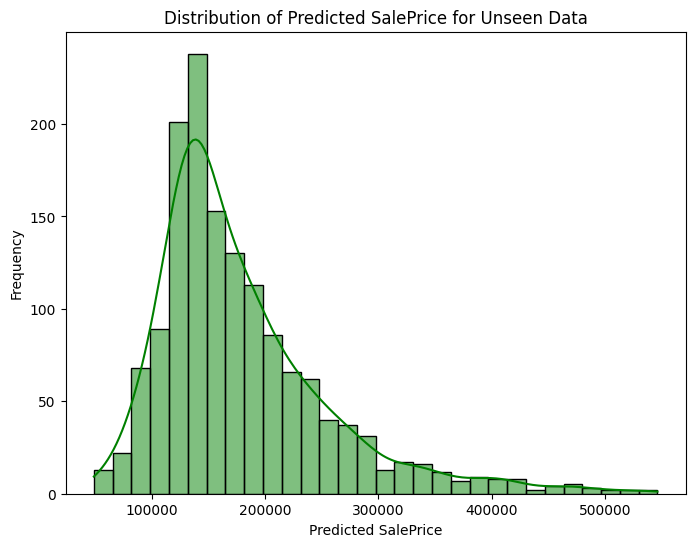

In [12]:
# Load the saved model
model = joblib.load('models/xgboost_model_1.pkl')

# Ensure no duplicate columns in df_final
df_final = df_final.loc[:, ~df_final.columns.duplicated()]

# Keep 'Id' column separately (if it exists)
if 'Id' in df_final.columns:
    id_column = df_final[['Id']].copy()  # Preserve the original Id column
else:
    id_column = None  # Handle cases where Id is missing

# Select relevant features for prediction (excluding Id)
features = ['OverallQual', 'InternalSF', 'GrLivArea', 'GarageCars', 'GarageArea', 'FullBath', 'YearBuilt', 'TotalBsmtSF',
         'YearRemodAdd', '1stFlrSF', 'BsmtFinSF1', 'LotArea', 'LotFrontage', 'Fireplaces', 'OverallCond', 'ExterQual_TA', 
         'Neighborhood_Price_Bucket_Level_1', 'Neighborhood_Price_Bucket_Level_4', 'KitchenQual_Gd', 'Neighborhood_Price_Bucket_Level_3']

unseen_df = df_final[features].copy()

# Make predictions on unseen data
unseen_predictions = model.predict(unseen_df)

# Store predictions in DataFrame
df_final['Predicted_SalePrice'] = unseen_predictions

# Ensure only one Id column is present
if id_column is not None and 'Id' not in df_final.columns:
    df_final = pd.concat([id_column, df_final], axis=1)

# Plot distribution of predicted SalePrice values
plt.figure(figsize=(8, 6))
sns.histplot(unseen_predictions, bins=30, kde=True, color='green')
plt.xlabel("Predicted SalePrice")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted SalePrice for Unseen Data")
plt.show()


In [13]:
# Create a data frame with the 'Id' and 'Predicted_SalePrice' columns
submission = df_final[['Id', 'Predicted_SalePrice']].copy()

# Rename the 'Predicted_SalePrice' column to 'SalePrice'
submission.rename(columns={'Predicted_SalePrice': 'SalePrice'}, inplace=True)

# Save the submission data frame to a CSV file
submission.to_csv('outputs/submission.csv', index=False)